OpenCV is a library of Python bindings designed to solve computer vision problems.

It's a great tool for image processing and performing computer vision tasks.

In [1]:
!pip install opencv-python numpy

In [2]:
# Import Libraries
import cv2
import numpy as np

Here we define the variables of weights and architectures for face, age, and gender detection models.

In [3]:
# https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
FACE_PROTO = "weights/deploy.prototxt.txt"
# https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20180205_fp16/res10_300x300_ssd_iter_140000_fp16.caffemodel
FACE_MODEL = "weights/res10_300x300_ssd_iter_140000_fp16.caffemodel"
# The gender model architecture
# https://drive.google.com/open?id=1W_moLzMlGiELyPxWiYQJ9KFaXroQ_NFQ
GENDER_MODEL = 'weights/deploy_gender.prototxt'
# The gender model pre-trained weights
# https://drive.google.com/open?id=1AW3WduLk1haTVAxHOkVS_BEzel1WXQHP
GENDER_PROTO = 'weights/gender_net.caffemodel'
# Each Caffe Model impose the shape of the input image also image preprocessing is required like mean
# substraction to eliminate the effect of illunination changes
MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
# Represent the gender classes
GENDER_LIST = ['Male', 'Female']
# The model architecture
# download from: https://drive.google.com/open?id=1kiusFljZc9QfcIYdU2s7xrtWHTraHwmW
AGE_MODEL = 'weights/deploy_age.prototxt'
# The model pre-trained weights
# download from: https://drive.google.com/open?id=1kWv0AjxGSN0g31OeJa02eBGM0R_jcjIl
AGE_PROTO = 'weights/age_net.caffemodel'
# Represent the 8 age classes of this CNN probability layer
AGE_INTERVALS = ['(0, 2)', '(4, 6)', '(8, 12)', '(15, 20)',
                 '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']

Loading the models:

In [4]:
# Initialize frame size
frame_width = 1280
frame_height = 720
# load face Caffe model
face_net = cv2.dnn.readNetFromCaffe(FACE_PROTO, FACE_MODEL)
# Load age prediction model
age_net = cv2.dnn.readNetFromCaffe(AGE_MODEL, AGE_PROTO)
# Load gender prediction model
gender_net = cv2.dnn.readNetFromCaffe(GENDER_MODEL, GENDER_PROTO)

We need a function to detect faces first:

In [5]:
def get_faces(frame, confidence_threshold=0.5):
    # convert the frame into a blob to be ready for NN input
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), (104, 177.0, 123.0))
    # set the image as input to the NN
    face_net.setInput(blob)
    # perform inference and get predictions
    output = np.squeeze(face_net.forward())
    # initialize the result list
    faces = []
    # Loop over the faces detected
    for i in range(output.shape[0]):
        confidence = output[i, 2]
        if confidence > confidence_threshold:
            box = output[i, 3:7] * \
                np.array([frame.shape[1], frame.shape[0],
                         frame.shape[1], frame.shape[0]])
            # convert to integers
            start_x, start_y, end_x, end_y = box.astype(np.int)
            # widen the box a little
            start_x, start_y, end_x, end_y = start_x - \
                10, start_y - 10, end_x + 10, end_y + 10
            start_x = 0 if start_x < 0 else start_x
            start_y = 0 if start_y < 0 else start_y
            end_x = 0 if end_x < 0 else end_x
            end_y = 0 if end_y < 0 else end_y
            # append to our list
            faces.append((start_x, start_y, end_x, end_y))
    return faces


If an input image exceeds a certain width, we need to resize an image.

In [6]:
# from: https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]
    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image
    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)
    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))
    # resize the image
    return cv2.resize(image, dim, interpolation = inter)

Now everything is ready, so we need to define detection functions.

In [7]:
def get_gender_predictions(face_img):
    blob = cv2.dnn.blobFromImage(
        image=face_img, scalefactor=1.0, size=(227, 227),
        mean=MODEL_MEAN_VALUES, swapRB=False, crop=False
    )
    gender_net.setInput(blob)
    return gender_net.forward()

In [8]:
def get_age_predictions(face_img):
    blob = cv2.dnn.blobFromImage(
        image=face_img, scalefactor=1.0, size=(227, 227),
        mean=MODEL_MEAN_VALUES, swapRB=False
    )
    age_net.setInput(blob)
    return age_net.forward()

And the main function is :

In [9]:
def predict_age_and_gender():
    """Predict the gender of the faces showing in the image"""
    # create a new cam object
    cap = cv2.VideoCapture(0)
    
    data = []
    while True:
        _, img = cap.read()
        # Take a copy of the initial image and resize it
        frame = img.copy()
        # resize if higher than frame_width
        if frame.shape[1] > frame_width:
            frame = image_resize(frame, width=frame_width)
        # predict the faces
        faces = get_faces(frame)
        # Loop over the faces detected
        # for idx, face in enumerate(faces):
        for i, (start_x, start_y, end_x, end_y) in enumerate(faces):
            face_img = frame[start_y: end_y, start_x: end_x]
            # predict age
            age_preds = get_age_predictions(face_img)
            # predict gender
            gender_preds = get_gender_predictions(face_img)
            i = gender_preds[0].argmax()
            gender = GENDER_LIST[i]
            gender_confidence_score = gender_preds[0][i]
            i = age_preds[0].argmax()
            age = AGE_INTERVALS[i]
            age_confidence_score = age_preds[0][i]
            # Draw the box
            label = f"{gender}-{gender_confidence_score*100:.1f}%, {age}-{age_confidence_score*100:.1f}%"
            data.append(label)
            # label = "{}-{:.2f}%".format(gender, gender_confidence_score*100)
#             print(label)
            
            yPos = start_y - 15
            while yPos < 15:
                yPos += 15
            box_color = (255, 0, 0) if gender == "Male" else (147, 20, 255)
            cv2.rectangle(frame, (start_x, start_y), (end_x, end_y), box_color, 2)
            # Label processed image
            cv2.putText(frame, label, (start_x, yPos),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.54, box_color, 2)

            # Display processed image
        cv2.imshow("Gender Estimator", frame)
        if cv2.waitKey(1) == ord("q"):
            break
        # uncomment if you want to save the image
        # cv2.imwrite("output.jpg", frame)
    # Cleanup
    cv2.destroyAllWindows()
    
    return data

In [10]:
import pandas as pd
# if __name__ == "__main__":
data = []
data = predict_age_and_gender()

C:\Users\F497~1\AppData\Local\Temp/ipykernel_18072/1409635499.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  start_x, start_y, end_x, end_y = box.astype(np.int)


In [11]:
df = pd.DataFrame(data)
df.rename(columns = {0:'info'}, inplace = True)
df

,info
0,"Male-75.8%, (8, 12)-60.3%"
1,"Male-78.6%, (8, 12)-58.6%"
2,"Male-78.6%, (8, 12)-58.6%"
3,"Male-78.2%, (8, 12)-56.8%"
4,"Male-85.6%, (8, 12)-52.1%"
...,...
88,"Male-97.8%, (15, 20)-82.7%"
89,"Male-99.0%, (15, 20)-77.7%"
90,"Male-99.0%, (15, 20)-77.7%"
91,"Male-93.3%, (15, 20)-86.9%"


In [12]:
df['info'] = df['info'].str.replace(',', '')
df['info'] = df['info'].str.replace('(', '')
df['info'] = df['info'].str.replace(')', '')
df['info'] = df['info'].str.replace('-', ' ')
df['info'] = df['info'].str.replace('%', '')

C:\Users\F497~1\AppData\Local\Temp/ipykernel_18072/52986846.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['info'] = df['info'].str.replace('(', '')
C:\Users\F497~1\AppData\Local\Temp/ipykernel_18072/52986846.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['info'] = df['info'].str.replace(')', '')


In [13]:
df

,info
0,Male 75.8 8 12 60.3
1,Male 78.6 8 12 58.6
2,Male 78.6 8 12 58.6
3,Male 78.2 8 12 56.8
4,Male 85.6 8 12 52.1
...,...
88,Male 97.8 15 20 82.7
89,Male 99.0 15 20 77.7
90,Male 99.0 15 20 77.7
91,Male 93.3 15 20 86.9


In [14]:
df = df['info'].str.split(' ', 5, expand=True).rename(
    columns={0:'Gender', 1:'gender_accuracy', 2:'age_min', 3:'age_max', 4:'age_accuracy'})

C:\Users\F497~1\AppData\Local\Temp/ipykernel_18072/3256387016.py:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df = df['info'].str.split(' ', 5, expand=True).rename(


In [15]:
df

,Gender,gender_accuracy,age_min,age_max,age_accuracy
0,Male,75.8,8,12,60.3
1,Male,78.6,8,12,58.6
2,Male,78.6,8,12,58.6
3,Male,78.2,8,12,56.8
4,Male,85.6,8,12,52.1
...,...,...,...,...,...
88,Male,97.8,15,20,82.7
89,Male,99.0,15,20,77.7
90,Male,99.0,15,20,77.7
91,Male,93.3,15,20,86.9


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Gender           93 non-null     object
 1   gender_accuracy  93 non-null     object
 2   age_min          93 non-null     object
 3   age_max          93 non-null     object
 4   age_accuracy     93 non-null     object
dtypes: object(5)
memory usage: 3.8+ KB


In [17]:
df[["gender_accuracy", "age_min", "age_max", "age_accuracy"]] = df[["gender_accuracy", "age_min", "age_max", "age_accuracy"]].apply(pd.to_numeric)

In [18]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

df['gender_int'] = le.fit_transform(df.Gender)

In [19]:
df

,Gender,gender_accuracy,age_min,age_max,age_accuracy,gender_int
0,Male,75.8,8,12,60.3,0
1,Male,78.6,8,12,58.6,0
2,Male,78.6,8,12,58.6,0
3,Male,78.2,8,12,56.8,0
4,Male,85.6,8,12,52.1,0
...,...,...,...,...,...,...
88,Male,97.8,15,20,82.7,0
89,Male,99.0,15,20,77.7,0
90,Male,99.0,15,20,77.7,0
91,Male,93.3,15,20,86.9,0


In [20]:
df.describe()

,gender_accuracy,age_min,age_max,age_accuracy,gender_int
count,93.000000,93.000000,93.000000,93.000000,93.0
mean,93.163441,9.580645,13.806452,79.407527,0.0
std,9.478165,2.942650,3.363028,13.494606,0.0
min,61.800000,8.000000,12.000000,50.700000,0.0
25%,90.500000,8.000000,12.000000,72.200000,0.0
50%,98.100000,8.000000,12.000000,84.500000,0.0
75%,99.500000,8.000000,12.000000,88.600000,0.0
max,99.900000,15.000000,20.000000,97.400000,0.0


In [21]:
import matplotlib.pyplot as plt

new_df = df.groupby(['Gender'])['Gender'].agg(['count']).reset_index()

In [22]:
new_df

,Gender,count
0,Male,93


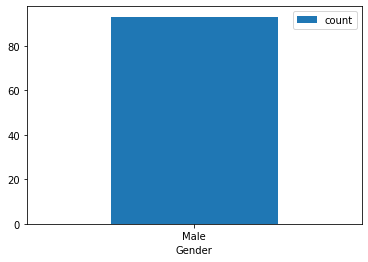

In [23]:
ax = new_df.plot.bar(x='Gender', y='count', rot=0)

In [24]:
df['age_mean'] = (df['age_min'] + df['age_max'])/2
df

,Gender,gender_accuracy,age_min,age_max,age_accuracy,gender_int,age_mean
0,Male,75.8,8,12,60.3,0,10.0
1,Male,78.6,8,12,58.6,0,10.0
2,Male,78.6,8,12,58.6,0,10.0
3,Male,78.2,8,12,56.8,0,10.0
4,Male,85.6,8,12,52.1,0,10.0
...,...,...,...,...,...,...,...
88,Male,97.8,15,20,82.7,0,17.5
89,Male,99.0,15,20,77.7,0,17.5
90,Male,99.0,15,20,77.7,0,17.5
91,Male,93.3,15,20,86.9,0,17.5


In [25]:
age_df = df.groupby(['age_mean'])['gender_accuracy'].agg(['count']).reset_index()
age_df

,age_mean,count
0,10.0,72
1,17.5,21


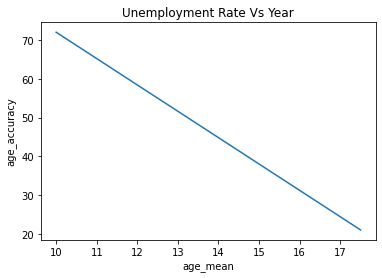

In [26]:
plt.plot(age_df['age_mean'], age_df['count'])
plt.title('Unemployment Rate Vs Year')
plt.xlabel('age_mean')
plt.ylabel('age_accuracy')
plt.show()